In [1]:
import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [16]:
output_dir = '../../split_income_models'

### Loading Data

In [2]:
filepath = '../../split_income_data'

In [3]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x90 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_90.csv')
    tdata_x90 = tdata_x90.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y90 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_90.csv')
    tdata_y90 = tdata_y90.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [4]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
test_data_x.shape

(302, 720)

In [6]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

### Setting up Tables

In [28]:
# setting up the dataframe to hold test results
index_rows = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 90%', '1'), ('Threshold 90%', '2'), ('Threshold 90%', '3'), ('Threshold 90%', '4'), ('Threshold 90%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

index_cols = pd.MultiIndex.from_tuples(
    [('LightGBM', 'Relative Error'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'Relative Error'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'Relative Error'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')],
    names=['Model', 'Evaluation Metric']
)

test_stats = pd.DataFrame(index=index_rows, columns=index_cols)

test_stats

Model                             LightGBM                            XGBoost  \
Evaluation Metric           Relative Error  MAE  MSE RMSE   R2 Relative Error   
Missing Data Threshold Fold                                                     
Threshold 85%          1               NaN  NaN  NaN  NaN  NaN            NaN   
                       2               NaN  NaN  NaN  NaN  NaN            NaN   
                       3               NaN  NaN  NaN  NaN  NaN            NaN   
                       4               NaN  NaN  NaN  NaN  NaN            NaN   
                       5               NaN  NaN  NaN  NaN  NaN            NaN   
Threshold 90%          1               NaN  NaN  NaN  NaN  NaN            NaN   
                       2               NaN  NaN  NaN  NaN  NaN            NaN   
                       3               NaN  NaN  NaN  NaN  NaN            NaN   
                       4               NaN  NaN  NaN  NaN  NaN            NaN   
                       5               NaN  NaN  NaN  NaN  NaN            NaN   
Threshold 95%          1               NaN  NaN  NaN  NaN  NaN            NaN   
                       2               NaN  NaN  NaN  NaN  NaN            NaN   
                       3               NaN  NaN  NaN  NaN  NaN            NaN   
                       4               NaN  NaN  NaN  NaN  NaN            NaN   
                       5               NaN  NaN  NaN  NaN  NaN            NaN   
None                   1               NaN  NaN  NaN  NaN  NaN            NaN   
                       2               NaN  NaN  NaN  NaN  NaN            NaN   
                       3               NaN  NaN  NaN  NaN  NaN            NaN   
                       4               NaN  NaN  NaN  NaN  NaN            NaN   
                       5               NaN  NaN  NaN  NaN  NaN            NaN   

Model                                            Random Forest                 \
Evaluation Metric            MAE  MSE RMSE   R2 Relative Error  MAE  MSE RMSE   
Missing Data Threshold Fold                                                     
Threshold 85%          1     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       2     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       3     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       4     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       5     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
Threshold 90%          1     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       2     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       3     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       4     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       5     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
Threshold 95%          1     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       2     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       3     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       4     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       5     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
None                   1     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       2     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       3     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       4     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   
                       5     NaN  NaN  NaN  NaN            NaN  NaN  NaN  NaN   

Model                             
Evaluation Metric             R2  
Missing Data Threshold Fold       
Threshold 85%          1     NaN  
                       2     NaN  
                       3     NaN  
                       4     NaN  
                       5   

### LightGBM

#### Data Collection

In [29]:
# setting up the dataframe to hold test results
lgbm_params = pd.DataFrame(index=index_rows, columns=['number_trees', 'max_tree_depth', 'boosting_type', 
                                                     'bagging_fraction', 'bagging_freq', 'learning_rate',
                                                     'l1_norm', 'l2_norm'])

In [30]:
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '90'
        elif thresh == 2:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        lgbm_params.loc[(thresh_name, fold_num)] = param_list

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        to_test = testing_x[train_input_data.columns].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate re
        num_predictions = len(prediction)
        re = 0
        for p in range(0, num_predictions):
            re += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        re = re/num_predictions
        #re = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'Relative Error')] = re[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_1426/3925599995.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'Relative Error')] = re[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_1426/3925599995.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'Relative Error')] = re[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_1426/3925599995.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

#### Visualisations

In [57]:
lgbm_params

number_trees max_tree_depth boosting_type  \
Missing Data Threshold Fold                                             
Threshold 85%          1             134             14          dart   
                       2             260              4          dart   
                       3             248             22          dart   
                       4             204             22          dart   
                       5              25              4          gbdt   
Threshold 90%          1             197              6          dart   
                       2              25             15          dart   
                       3             196              8          dart   
                       4             300              6          dart   
                       5             114             22          gbdt   
Threshold 95%          1             179             18          dart   
                       2              10              5          dart   
                       3             150             13          dart   
                       4             180             14          dart   
                       5              11             10          gbdt   
None                   1              45             24          dart   
                       2             116              3          dart   
                       3             130              9          dart   
                       4             284              6          dart   
                       5             280              5          gbdt   

                            bagging_fraction bagging_freq learning_rate  \
Missing Data Threshold Fold                                               
Threshold 85%          1             0.61369            2      0.066726   
                       2            0.214802            2      0.260133   
                       3            0.134161            3        0.0991   
                       4            0.621554           10      0.087663   
                       5            0.300908           10      0.215157   
Threshold 90%          1            0.399294            1      0.049445   
                       2            0.763089            4      0.288883   
                       3            0.215975            6      0.047772   
                       4             0.45632            2      0.084172   
                       5            0.640339            2      0.045939   
Threshold 95%          1             0.19214            3      0.099909   
                       2            0.931418            4      0.474986   
                       3            0.197639            2      0.052428   
                       4            0.476467            5      0.251377   
                       5            0.727589            9      0.776504   
None                   1            0.435869            1      0.108756   
                       2            0.599909            1      0.142531   
                       3            0.155107            5      0.091006   
                       4            0.408732            7      0.112992   
                       5            0.174789            2      0.141025   

                              l1_norm   l2_norm  
Missing Data Threshold Fold                      
Threshold 85%          1     0.000941  0.000106  
                       2     0.000557  0.000329  
                       3     0.000389  0.000496  
                       4     0.000229  0.000458  
                       5     0.000423  0.000044  
Threshold 90%          1     0.000153  0.000735  
                       2     0.000481  0.000468  
                       3     0.000242  0.000247  
                       4     0.000417  0.000528  
                       5     0.000159  0.000356  
Threshold 95%          1     0.000697  0.000592  
                       2     0.000596  0.000511  
                       3     0.000009  0.000019  
                    

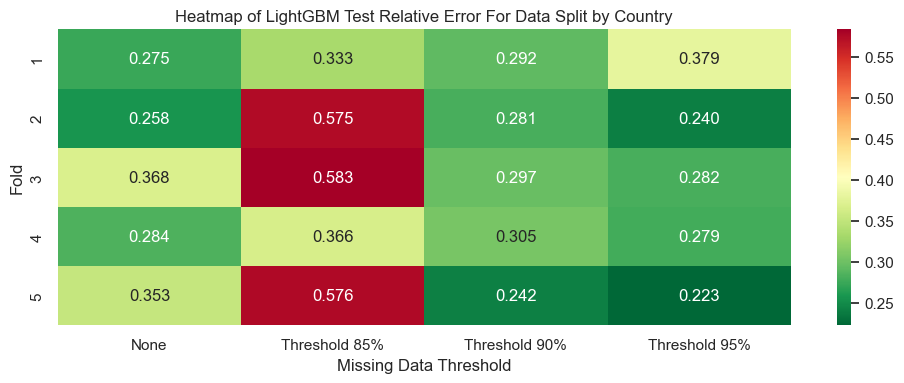

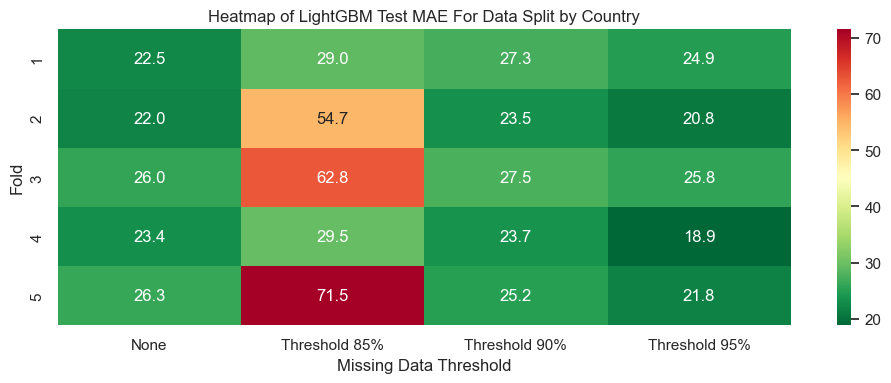

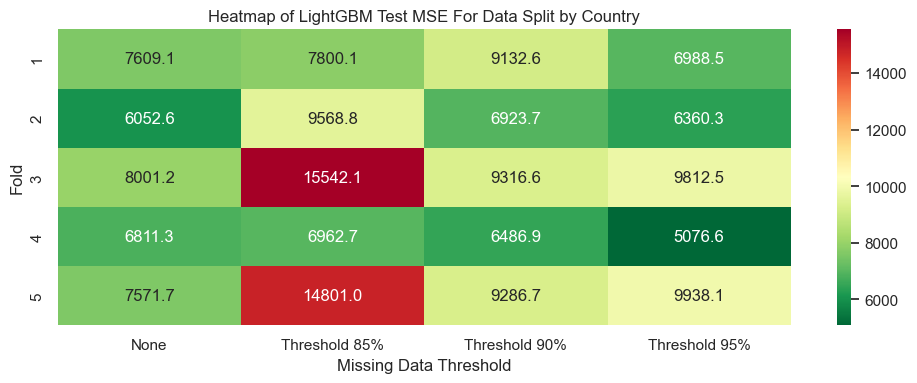

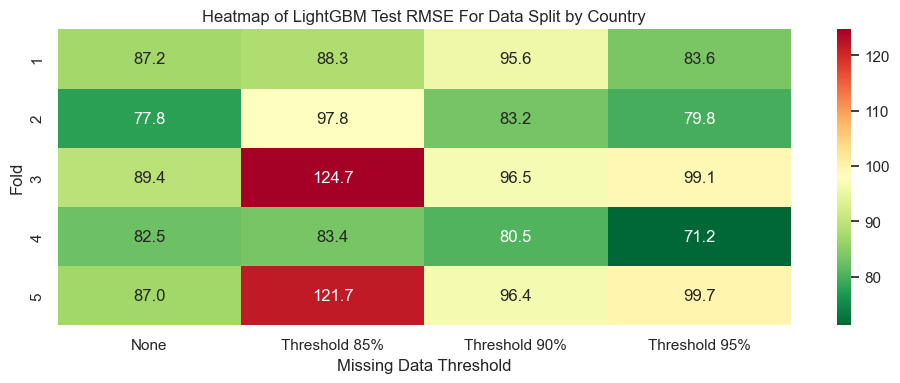

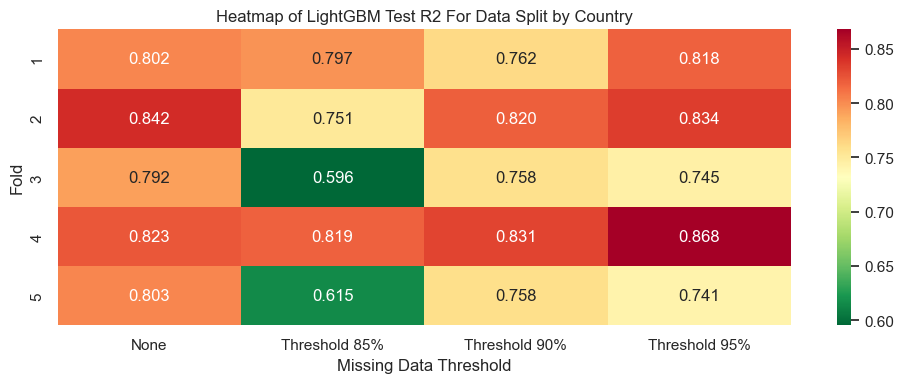

In [58]:
import seaborn as sns

data_lgbm = test_stats['LightGBM'].astype(float)

for metric in data_lgbm.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_lgbm[metric].unstack(level='Missing Data Threshold'))
    if metric == 'Relative Error' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of LightGBM Test " + metric + " For Data Split by Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [59]:
pd.DataFrame(data_lgbm['Relative Error'].unstack(level='Missing Data Threshold'))

Missing Data Threshold,None,Threshold 85%,Threshold 90%,Threshold 95%
Fold,,,,
1,0.274535,0.332904,0.292077,0.379108
2,0.257526,0.574682,0.281356,0.240078
3,0.367955,0.583133,0.296668,0.281661
4,0.284388,0.366146,0.304871,0.278622
5,0.353068,0.575740,0.241646,0.222704


In [60]:
(0.573279 - 0.422713)/((0.456556 + 0.422713 + 0.496534 + 0.573279 + 0.474209)/5)

0.31066429908748056

In [61]:
((d.max() - d.min()) / d.mean()) * 100

Missing Data Threshold
None              6.242527
Threshold 85%    31.211289
Threshold 90%     9.371646
Threshold 95%    15.790262
dtype: float64

In [62]:
lgbm_data = test_stats['LightGBM'].astype(float)
mean_summary_lgbm = lgbm_data.groupby(level='Missing Data Threshold').mean()
mean_summary_lgbm = mean_summary_lgbm.astype('float')
mean_summary_lgbm = mean_summary_lgbm.round(2)
std_summary_lgbm = lgbm_data.groupby(level='Missing Data Threshold').std()
std_summary_lgbm = std_summary_lgbm.astype('float')
std_summary_lgbm = std_summary_lgbm.round(2)

In [63]:
mean_corr_lgbm = mean_summary_lgbm.corr()
mean_corr_lgbm

Evaluation Metric,Relative Error,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
Relative Error,1.000000,0.986142,0.930269,0.919617,-0.945889
MAE,0.986142,1.000000,0.977020,0.971622,-0.984316
MSE,0.930269,0.977020,1.000000,0.999058,-0.998471
RMSE,0.919617,0.971622,0.999058,1.000000,-0.995266
R2,-0.945889,-0.984316,-0.998471,-0.995266,1.000000


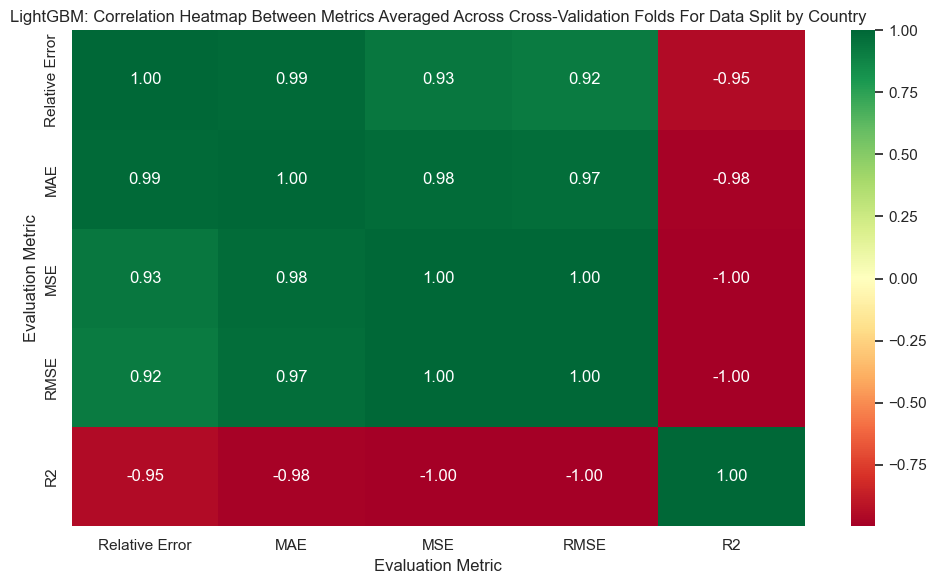

In [64]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_lgbm, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Country")
plt.tight_layout()
plt.show()

### XGBoost

#### Data Collection

In [31]:
xgb_params = pd.DataFrame(index=index_rows, columns=['n_estimators', 'max_depth', 'booster', 
                                                     'subsample', 'learning_rate','reg_alpha', 'reg_lambda'])

In [32]:
testing_x = test_data_x.copy()

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '90'
        elif thresh == 2:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/xgboost/best_params_{fold}_{name}.pkl")

        param_list = list(best_params.values())
        xgb_params.loc[(thresh_name, fold_num)] = param_list

        train_input_data = train[fold][thresh * 2].copy()

        train_label = train[fold][thresh * 2 + 1].copy()

        to_test = testing_x[train_input_data.columns].copy()

        loaded_model = xgb.XGBRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate re
        num_predictions = len(prediction)
        re = 0
        for p in range(0, num_predictions):
            re += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        re = re/num_predictions
        #re = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'Relative Error')] = re[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_1426/1122550296.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'Relative Error')] = re[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_1426/1122550296.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'Relative Error')] = re[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_1426/1122550296.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

#### Visualisations

In [67]:
xgb_params

n_estimators max_depth booster subsample  \
Missing Data Threshold Fold                                            
Threshold 85%          1              30         4    dart  0.998612   
                       2             193         3  gbtree  0.376138   
                       3              10         5    dart  0.217688   
                       4             263         5  gbtree  0.885954   
                       5             174        21    dart  0.564344   
Threshold 90%          1              15         5  gbtree  0.667414   
                       2              52         3  gbtree  0.744818   
                       3             200        20  gbtree  0.831316   
                       4              72         4    dart   0.21792   
                       5             204        22  gbtree  0.321983   
Threshold 95%          1              82         5    dart  0.497808   
                       2             252        22  gbtree  0.504713   
                       3             106         8    dart   0.10423   
                       4             152        10  gbtree  0.166401   
                       5             286        14  gbtree  0.344958   
None                   1             104         4  gbtree  0.957164   
                       2              60         3  gbtree  0.571063   
                       3              14         8    dart  0.173566   
                       4             147         7  gbtree  0.269564   
                       5              21        15    dart  0.776152   

                            learning_rate reg_alpha reg_lambda  
Missing Data Threshold Fold                                     
Threshold 85%          1          0.06812  0.000752   0.000034  
                       2         0.054921  0.000843   0.000385  
                       3          0.15988  0.000781   0.000326  
                       4         0.530282   0.00081   0.000801  
                       5         0.568774  0.000543   0.000899  
Threshold 90%          1         0.123166  0.000334   0.000646  
                       2         0.049254  0.000739   0.000846  
                       3         0.452131  0.000543   0.000834  
                       4         0.108818   0.00046   0.000557  
                       5         0.243902  0.000073   0.000973  
Threshold 95%          1         0.026647  0.000948   0.000037  
                       2         0.148269  0.000974   0.000088  
                       3         0.014594   0.00035   0.000413  
                       4         0.019045  0.000591   0.000657  
                       5         0.221378   0.00036   0.000243  
None                   1         0.018849  0.000511   0.000014  
                       2         0.042579  0.000935   0.000909  
                       3         0.095876  0.000001   0.000871  
                       4         0.026487  0.000203    0.00046  
                       5         0.296356  0.000559   0.000795

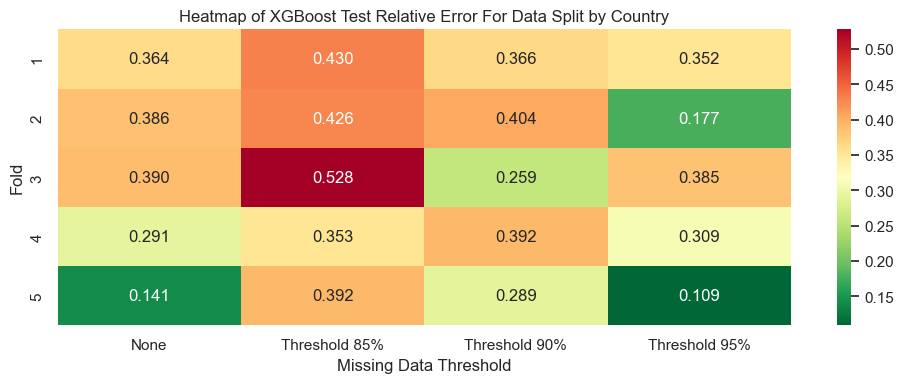

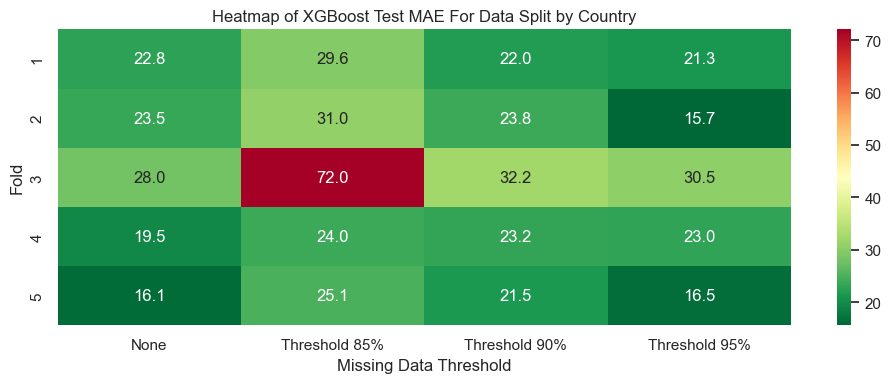

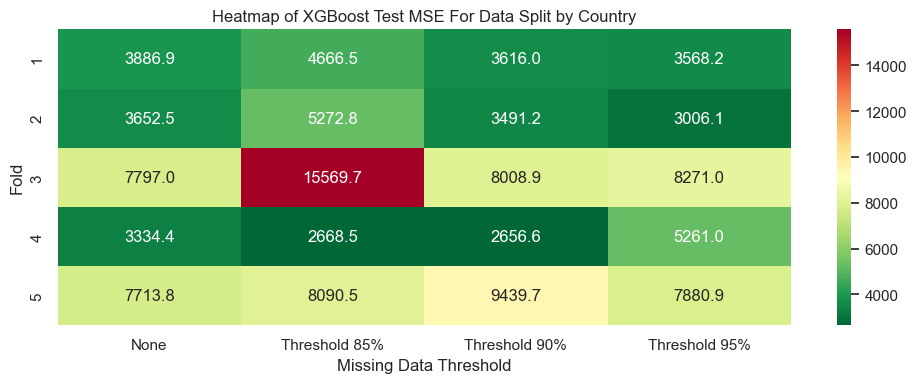

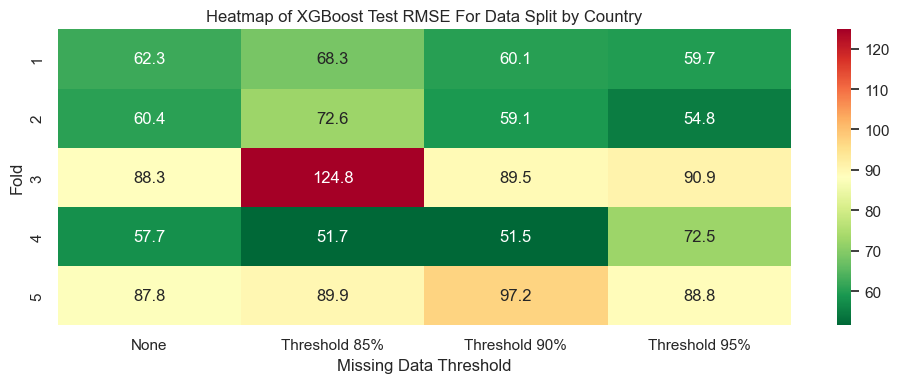

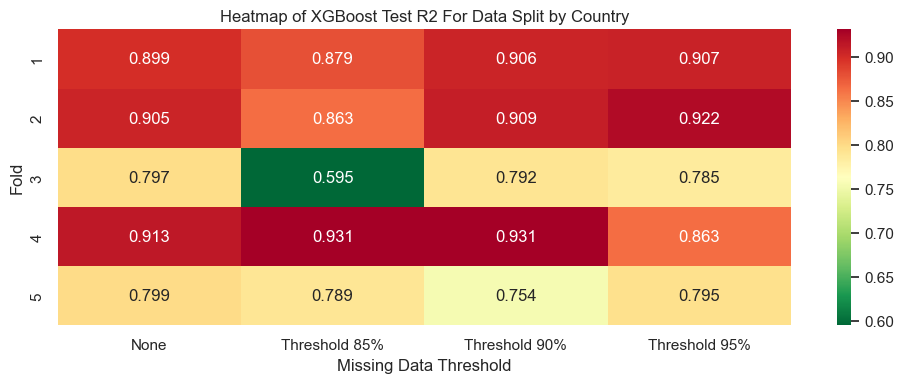

In [68]:
import seaborn as sns

data_xgb = test_stats['XGBoost'].astype(float)

for metric in data_xgb.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_xgb[metric].unstack(level='Missing Data Threshold'))
    if metric == 'Relative Error' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of XGBoost Test " + metric + " For Data Split by Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [69]:
xgb_data = test_stats['XGBoost'].astype(float)
mean_summary_xgb = xgb_data.groupby(level='Missing Data Threshold').mean()
mean_summary_xgb = mean_summary_xgb.astype('float')
mean_summary_xgb = mean_summary_xgb.round(2)
std_summary_xgb = xgb_data.groupby(level='Missing Data Threshold').std()
std_summary_xgb = std_summary_xgb.astype('float')
std_summary_xgb = std_summary_xgb.round(2)

In [70]:
mean_corr_xgb = mean_summary_xgb.corr()
mean_corr_xgb

Evaluation Metric,Relative Error,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
Relative Error,1.000000,0.964204,0.864140,0.818733,-0.813310
MAE,0.964204,1.000000,0.966232,0.939878,-0.936204
MSE,0.864140,0.966232,1.000000,0.995651,-0.994366
RMSE,0.818733,0.939878,0.995651,1.000000,-0.999902
R2,-0.813310,-0.936204,-0.994366,-0.999902,1.000000


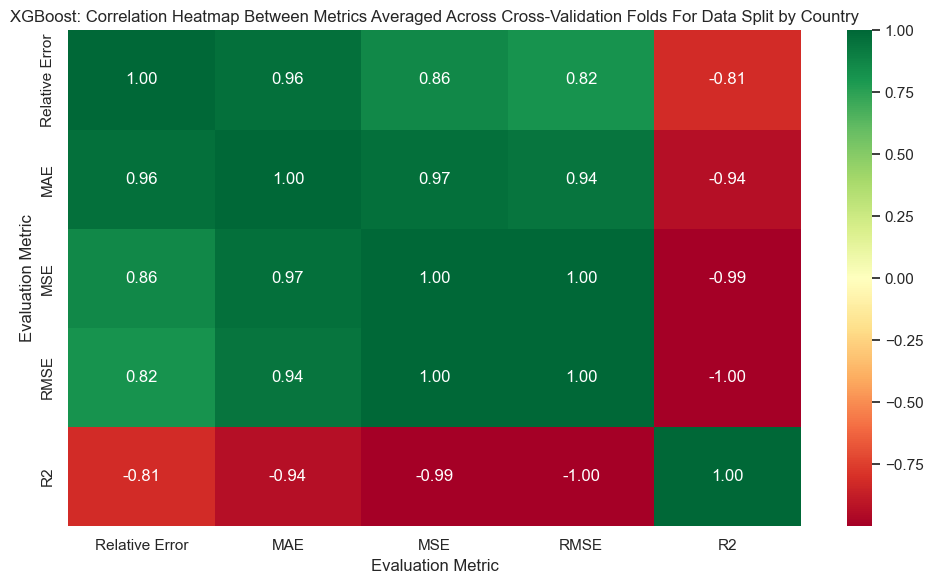

In [71]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_xgb, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("XGBoost: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Country")
plt.tight_layout()
plt.show()

### Random Forest

#### Data Collection

In [33]:
rf_params = pd.DataFrame(index=index_rows, columns=['n_estimators', 'max_depth', 'min_samples_split', 
                                                     'bootstrapping', 'max_samples'])

In [34]:
testing_x_rf = testing_x.copy()

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '90'
        elif thresh == 2:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/rf/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        if param_list[3] == False:
            param_list.append('NA')
        rf_params.loc[(thresh_name, fold_num)] = param_list
        train_input_data = train[fold][thresh * 2].copy()

        test_relevant_input = testing_x_rf[train_input_data.columns]

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        prediction = train_load.predict(test_relevant_input)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate re
        num_predictions = len(prediction)
        re = 0
        for p in range(0, num_predictions):
            re += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        
        re = re/num_predictions

        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'Relative Error')] = re[0]
        

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_1426/1825667534.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'Relative Error')] = re[0]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_14

#### Visualisations

In [74]:
rf_params

n_estimators max_depth min_samples_split  \
Missing Data Threshold Fold                                            
Threshold 85%          1             258         3                 5   
                       2              43        22                 3   
                       3             188        17                 2   
                       4             161         3                 2   
                       5              14        10                 5   
Threshold 90%          1             198        21                 6   
                       2              51        16                 6   
                       3              23        24                 3   
                       4              87        21                 2   
                       5              10        17                 7   
Threshold 95%          1             183        20                 3   
                       2              14         3                 4   
                       3              32        12                 3   
                       4              15        12                 3   
                       5              10         7                 3   
None                   1              13        14                 3   
                       2              10         6                 2   
                       3              34         3                 5   
                       4              10        21                 4   
                       5              10        22                 4   

                            bootstrapping max_samples  
Missing Data Threshold Fold                            
Threshold 85%          1             True    0.086273  
                       2             True    0.052085  
                       3             True    0.045885  
                       4             True    0.107398  
                       5             True    0.979161  
Threshold 90%          1             True    0.105061  
                       2             True    0.158619  
                       3             True    0.083443  
                       4             True    0.083846  
                       5            False          NA  
Threshold 95%          1             True    0.099286  
                       2             True    0.522734  
                       3             True    0.098858  
                       4             True    0.197013  
                       5             True     0.65126  
None                   1             True    0.041995  
                       2             True    0.472033  
                       3             True    0.134292  
                       4             True    0.716895  
                       5             True    0.705501

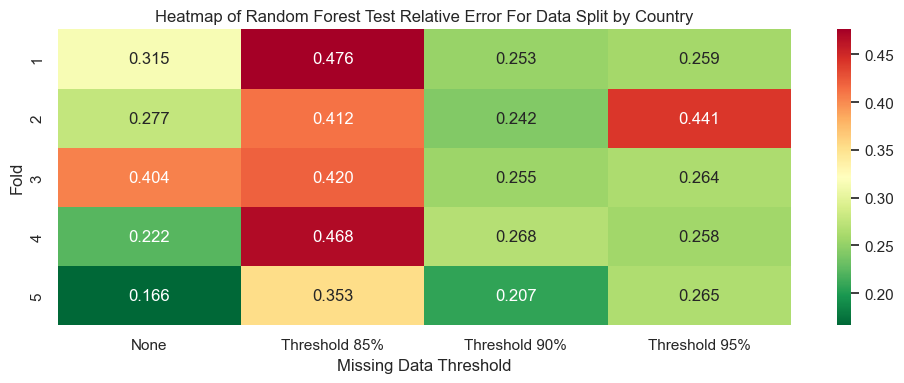

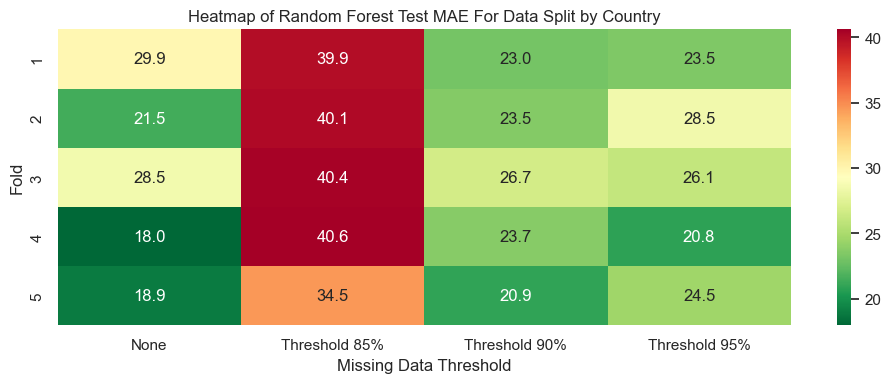

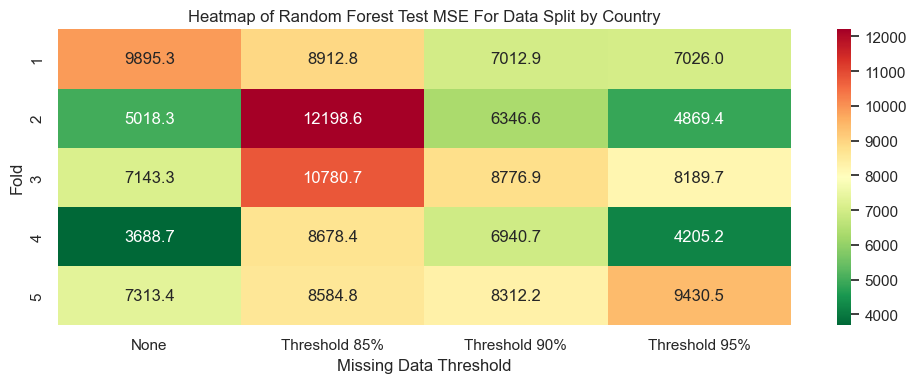

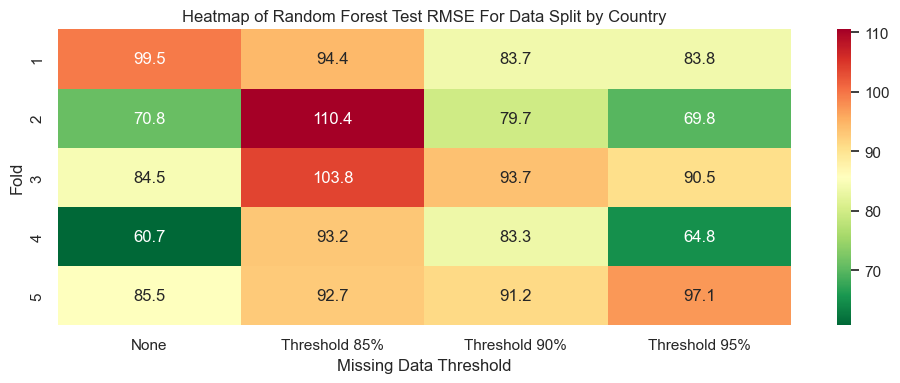

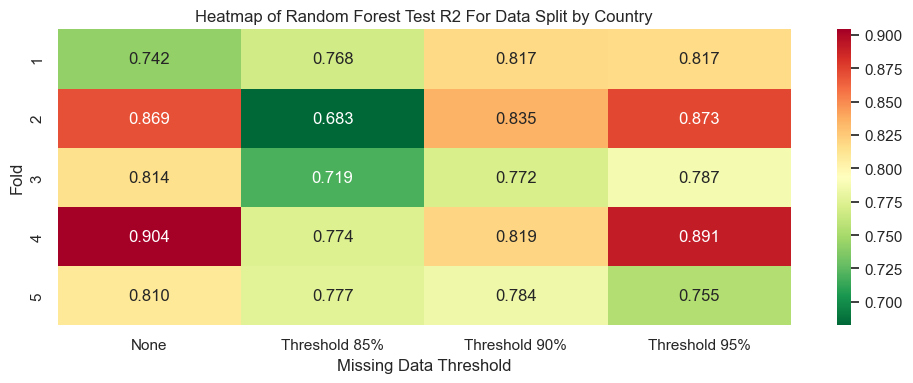

In [75]:
import seaborn as sns

data_rf = test_stats['Random Forest'].astype(float)

for metric in data_rf.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_rf[metric].unstack(level='Missing Data Threshold'))
    if metric == 'Relative Error' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric + " For Data Split by Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [76]:
rf_data = test_stats['Random Forest'].astype(float)
mean_summary_rf = rf_data.groupby(level='Missing Data Threshold').mean()
mean_summary_rf = mean_summary_rf.astype('float')
mean_summary_rf = mean_summary_rf.round(2)
std_summary_rf = rf_data.groupby(level='Missing Data Threshold').std()
std_summary_rf = std_summary_rf.astype('float')
std_summary_rf = std_summary_rf.round(2)

In [77]:
mean_corr_rf = mean_summary_rf.corr()
mean_corr_rf

Evaluation Metric,Relative Error,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
Relative Error,1.000000,0.976459,0.877641,0.849626,-0.915533
MAE,0.976459,1.000000,0.960335,0.943158,-0.979713
MSE,0.877641,0.960335,1.000000,0.998282,-0.994729
RMSE,0.849626,0.943158,0.998282,1.000000,-0.989111
R2,-0.915533,-0.979713,-0.994729,-0.989111,1.000000


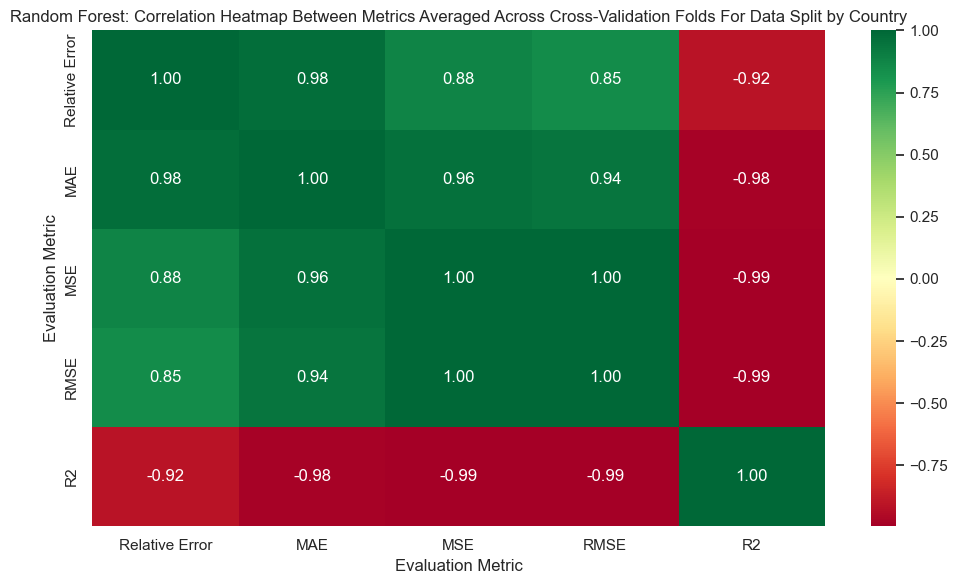

In [78]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_rf, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("Random Forest: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Country")
plt.tight_layout()
plt.show()

### Comparison Visualisations

In [35]:
test_stats

Model                             LightGBM                           \
Evaluation Metric           Relative Error        MAE           MSE   
Missing Data Threshold Fold                                           
Threshold 85%          1          0.332904  29.034317   7800.138004   
                       2          0.574682  54.729776   9568.775277   
                       3          0.583133   62.79316  15542.092605   
                       4          0.366146  29.455513   6962.659291   
                       5           0.57574  71.473001  14801.033273   
Threshold 90%          1          0.292077  27.264593   9132.584315   
                       2          0.281356   23.48941   6923.732907   
                       3          0.296668  27.541757   9316.586616   
                       4          0.304871  23.664755   6486.923816   
                       5          0.241646  25.212895   9286.699758   
Threshold 95%          1          0.379108  24.926184   6988.532148   
                       2          0.240078   20.79548   6360.304487   
                       3          0.281661  25.833852   9812.473098   
                       4          0.278622  18.901041   5076.557798   
                       5          0.222704   21.84144   9938.062294   
None                   1          0.274535  22.473332   7609.121377   
                       2          0.257526  21.997872   6052.610125   
                       3          0.367955  25.998453    8001.15233   
                       4          0.284388  23.406987   6811.319204   
                       5          0.353068  26.276193   7571.705175   

Model                                                    XGBoost             \
Evaluation Metric                  RMSE        R2 Relative Error        MAE   
Missing Data Threshold Fold                                                   
Threshold 85%          1       88.31839  0.796994       0.429688  29.574995   
                       2      97.820117  0.750963       0.426475  30.955957   
                       3     124.667929  0.595502       0.527596   72.02433   
                       4      83.442551   0.81879       0.352581  23.964977   
                       5     121.659497  0.614789       0.392254  25.101273   
Threshold 90%          1      95.564556  0.762316       0.365711   22.04693   
                       2      83.208971  0.819803       0.404192  23.835268   
                       3      96.522467  0.757527        0.25915  32.215004   
                       4      80.541442  0.831172       0.392158  23.179279   
                       5      96.367524  0.758305       0.289077  21.481995   
Threshold 95%          1      83.597441  0.818117       0.351525  21.258965   
                       2      79.751517  0.834467       0.176863  15.666427   
                       3      99.057928  0.744621       0.384976  30.533274   
                       4      71.249967  0.867878       0.308708  23.026426   
                       5       99.68983  0.741352       0.109031  16.521048   
None                   1      87.230278  0.801965       0.363516  22.751688   
                       2      77.798523  0.842475       0.385646  23.519583   
                       3      89.449161  0.791762       0.389565  28.007839   
                       4      82.530717  0.822729       0.290735  19.480915   
                       5      87.015546  0.802939       0.141419  16.108938   

Model                                                            \
Evaluation Metric                     MSE        RMSE        R2   
Missing Data Threshold Fold                                       
Threshold 85%          1      4666.504883   68.311821   0.87855   
                       2      5272.804688   72.614081   0.86277   
                       3     15569.662109  124.778452  0.594785   
                       4      2668.512939   51.657651  0.930549   
                       5      8090.496094   89.947185  0.789437   
Threshold 90

In [5]:
mean_concat = pd.concat([mean_summary_lgbm, mean_summary_xgb, mean_summary_rf], axis=1)
mean_concat.columns = pd.MultiIndex.from_tuples([('LightGBM', 'Relative Error'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'Relative Error'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'Relative Error'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')], names=['Model', 'Metric'])
mean_concat

NameError: name 'mean_summary_lgbm' is not defined

In [2]:
mean_concat = mean_concat.loc[['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']]

NameError: name 'mean_concat' is not defined

In [122]:
std_concat = pd.concat([std_summary_lgbm, std_summary_xgb, std_summary_rf], axis=1)
std_concat.columns = pd.MultiIndex.from_tuples([('LightGBM', 'Relative Error'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'Relative Error'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'Relative Error'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')], names=['Model', 'Metric'])
std_concat = std_concat.loc[['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']]

In [123]:
joblib.dump(mean_concat, f"../../split_income_models/base_mean_metrics.pkl")
joblib.dump(std_concat, f"../../split_income_models/base_std_metrics.pkl")

['../../split_income_models/base_std_metrics.pkl']

In [6]:
mean_concat = joblib.load("../../split_income_models/base_mean_metrics.pkl")
std_concat = joblib.load("../../split_income_models/base_std_metrics.pkl")

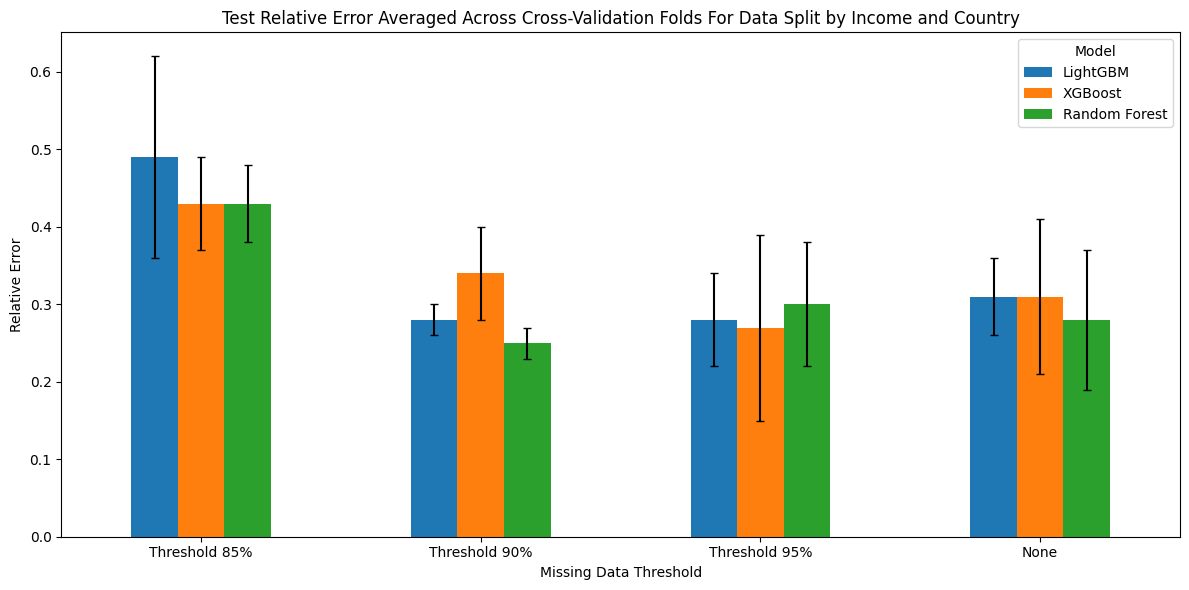

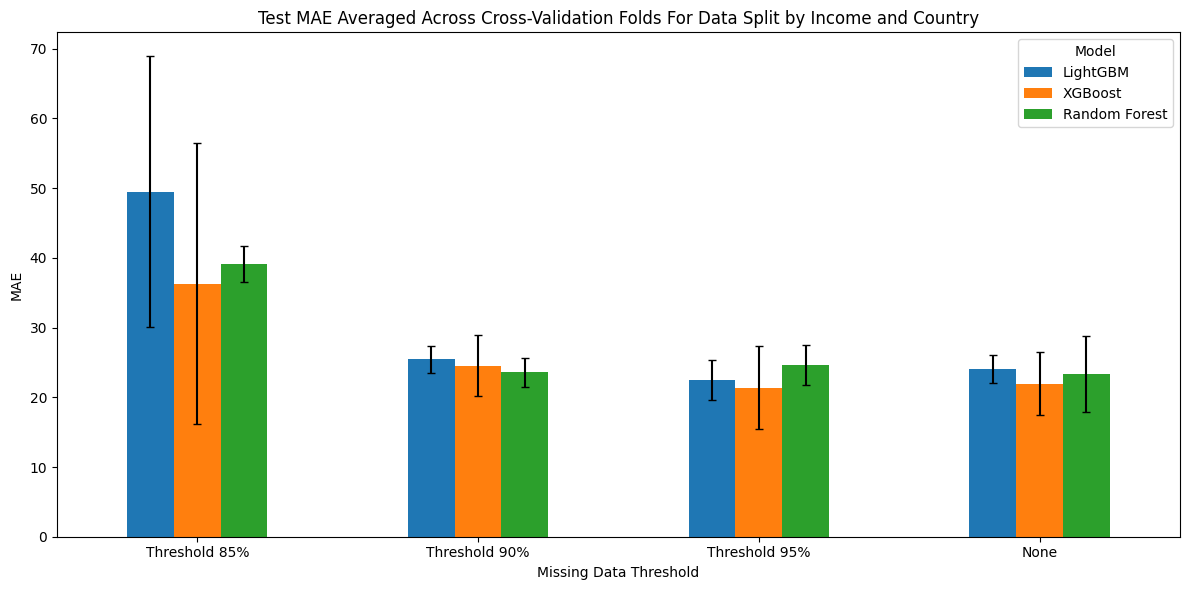

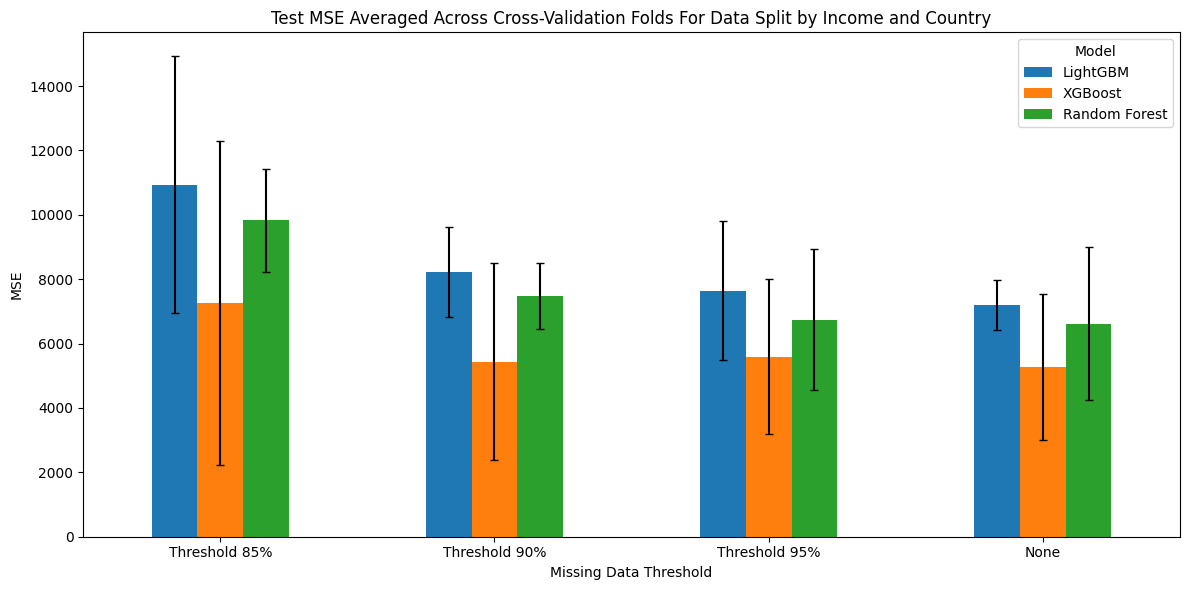

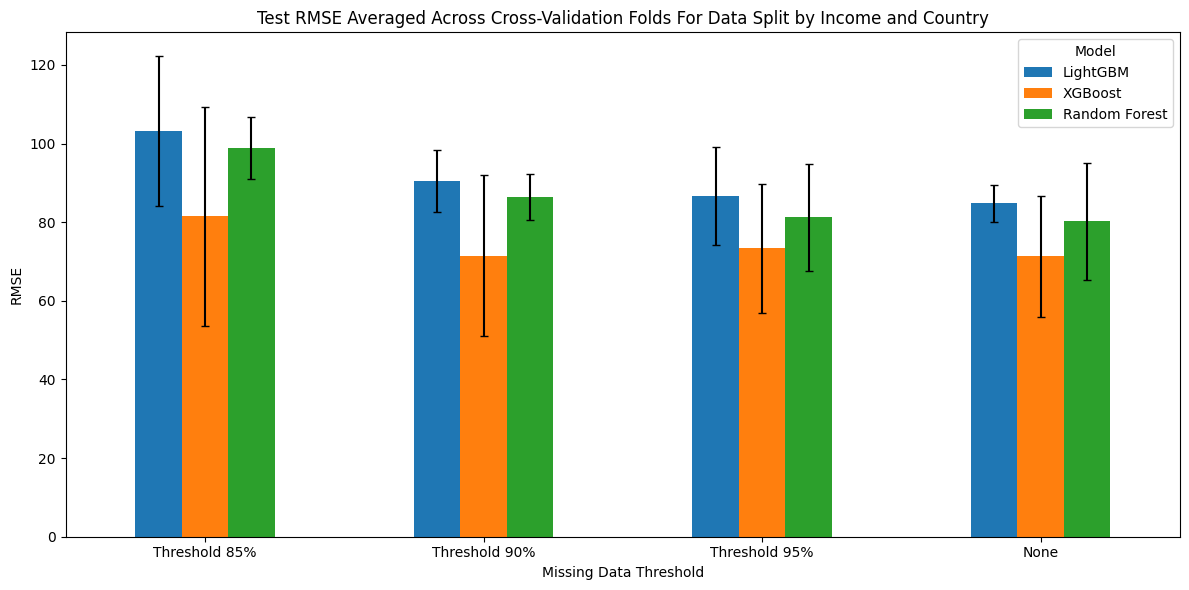

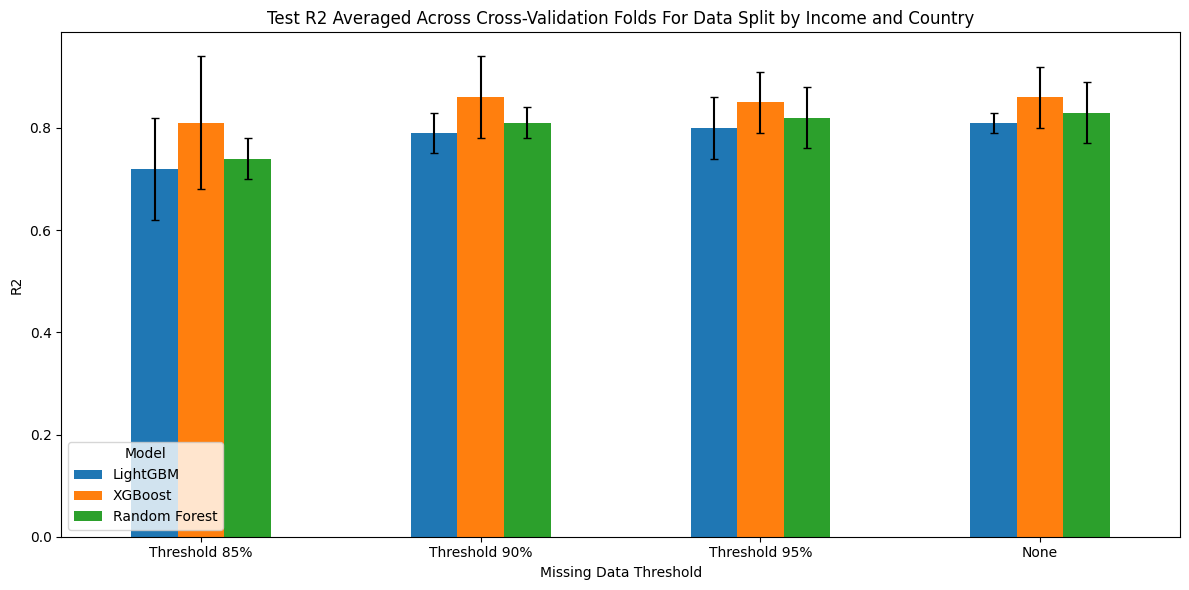

In [8]:
mean_concat = mean_concat.astype(float)
std_concat = std_concat.astype(float)

metrics = ['Relative Error', 'MAE', "MSE", 'RMSE', "R2"]
bar_index = ['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'Threshold 100%'] # mean_concat.index

for metric in metrics:
    data_metric = mean_concat.xs(metric, axis=1, level='Metric')
    error = std_concat.xs(metric, axis=1, level='Metric')
    ax = data_metric.plot.bar(rot=0, yerr=error, figsize=(12, 6), capsize=3)     
    plt.title("Test " + metric + " Averaged Across Cross-Validation Folds For Data Split by Income and Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

### Without XGBoost

In [126]:
without_xgb = mean_concat.drop(columns=['XGBoost'], axis=1)
without_xgb_std = std_concat.drop(columns=['XGBoost'], axis=1)

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_77786/2683943296.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  without_xgb = mean_concat.drop(columns=['XGBoost'], axis=1)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_77786/2683943296.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  without_xgb_std = std_concat.drop(columns=['XGBoost'], axis=1)


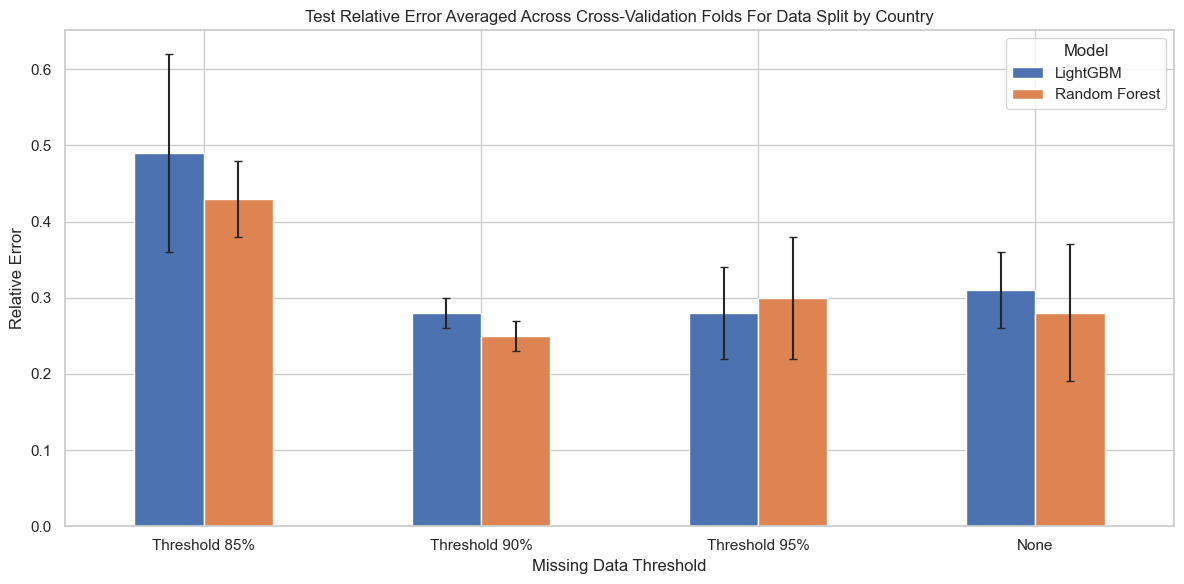

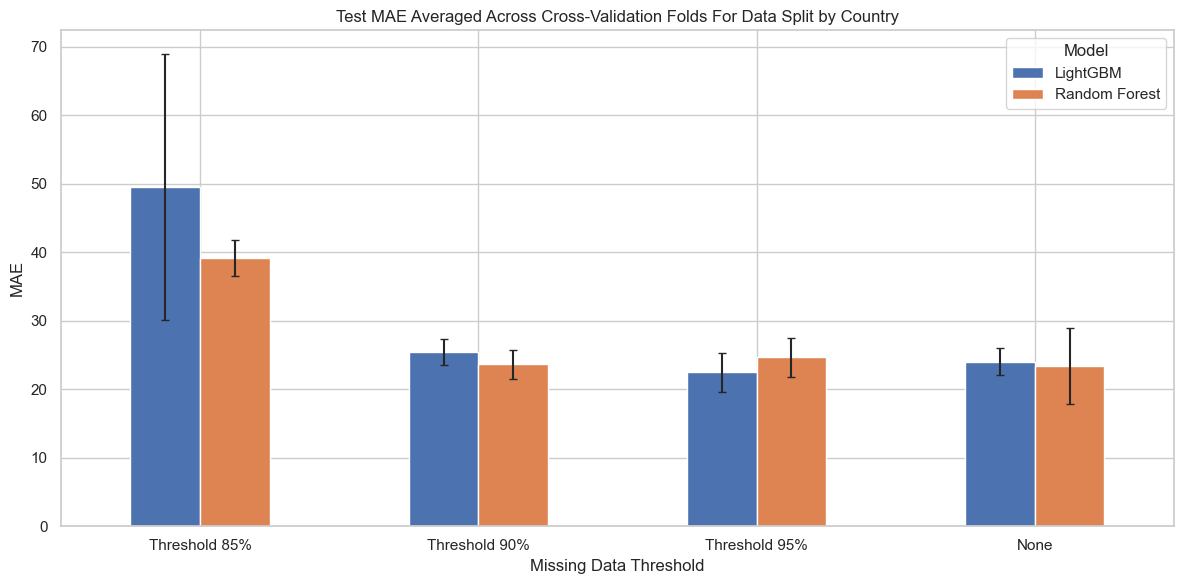

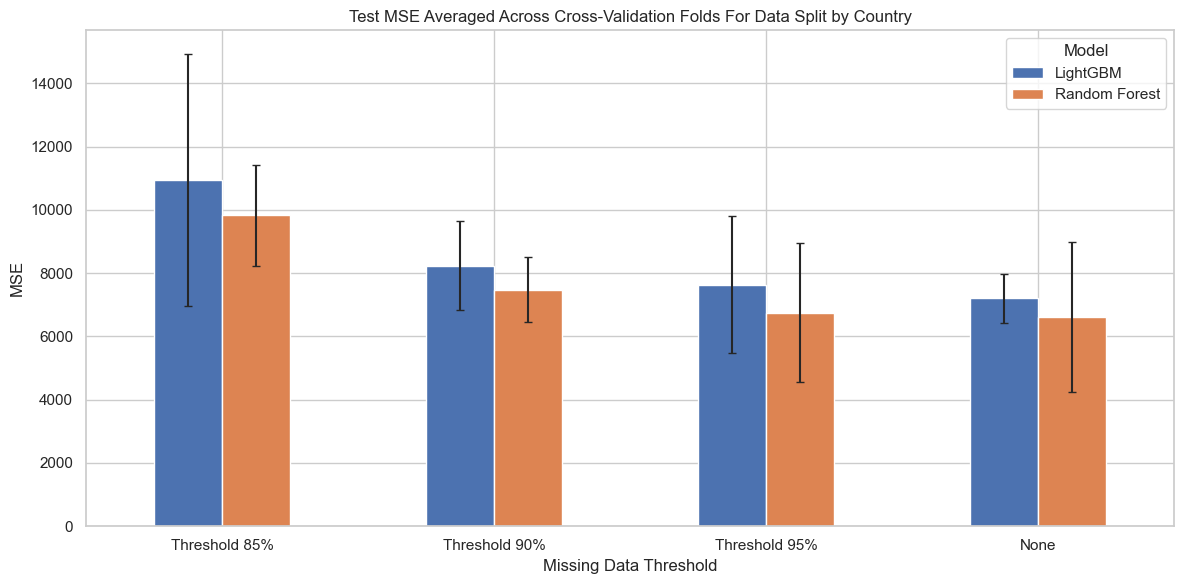

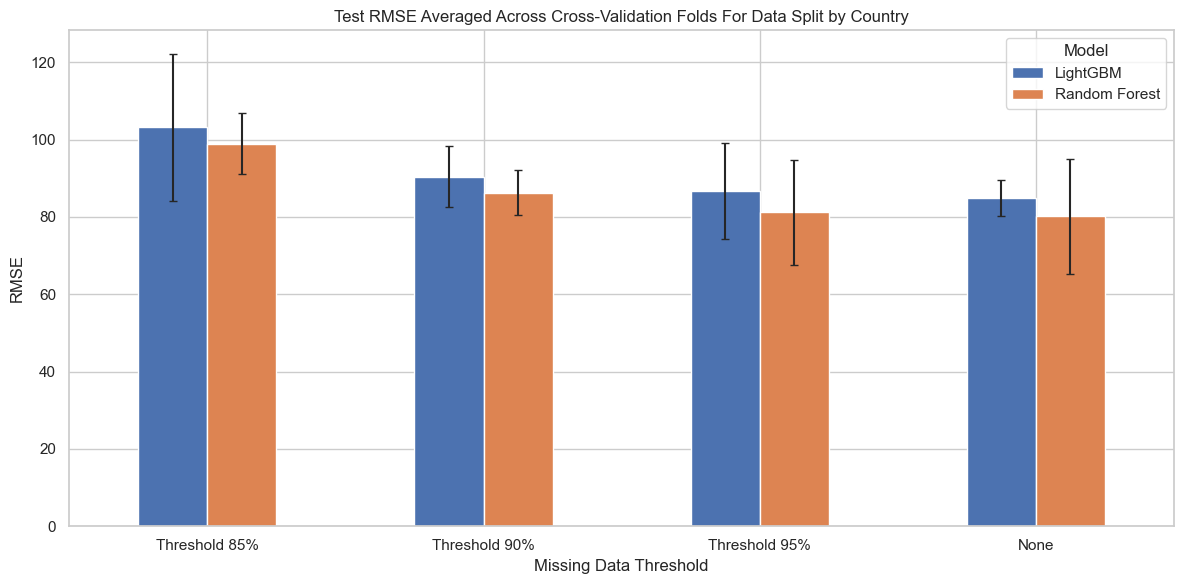

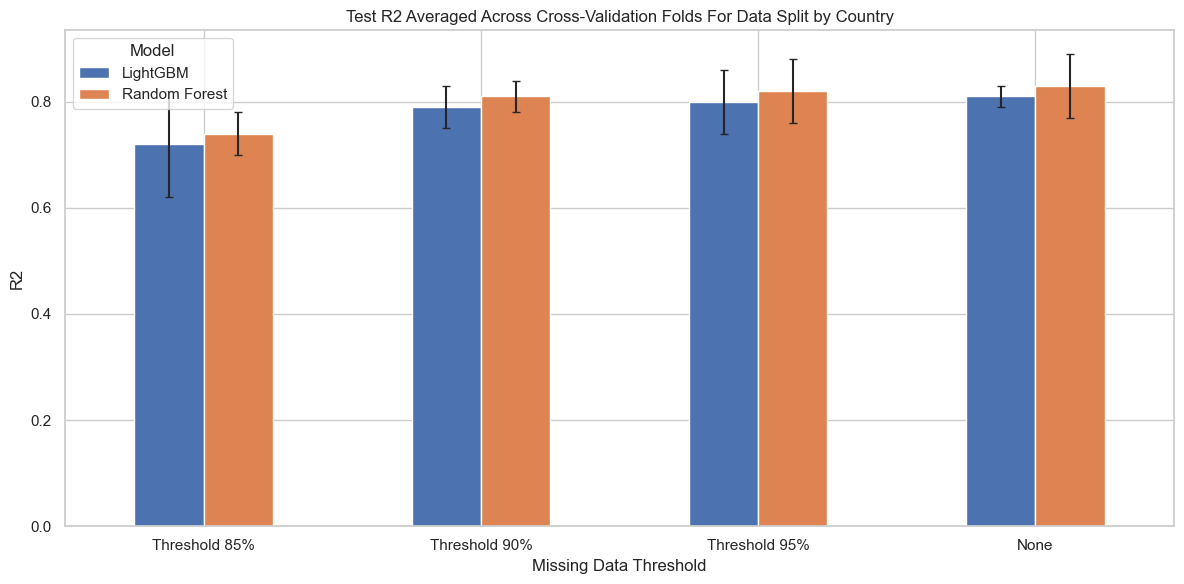

In [148]:
without_xgb = without_xgb.astype(float)
without_xgb_std = without_xgb_std.astype(float)

metrics = ['Relative Error', 'MAE', "MSE", 'RMSE', "R2"]
bar_index = without_xgb.index

for metric in metrics:
    data_metric = without_xgb.xs(metric, axis=1, level='Metric')
    error = without_xgb_std.xs(metric, axis=1, level='Metric')
    ax = data_metric.plot.bar(rot=0, yerr=error, figsize=(12, 6), capsize=3)     
    plt.title("Test " + metric + " Averaged Across Cross-Validation Folds For Data Split by Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

### Test vs Validation

#### Data Gathering

In [128]:
validation_mse_stats = pd.DataFrame(index=index_rows, columns=['xgboost', 'lightgbm', 'random_forest'])

In [129]:
for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
        for model in ['xgboost', 'lightgbm', 'rf']:
        
            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            if model == 'rf':
                model_name = 'random_forest'
            else:
                model_name = model

            with open(f"{output_dir}/{model}/results_{fold}_{name}.json", 'r') as f:
                optuna_study = json.load(f)

            best_value = optuna_study["best_optuna_loss"]

            validation_mse_stats.loc[(thresh_name, fold_num), model_name] = best_value

In [130]:
mean_validation_mse = validation_mse_stats.groupby(level='Missing Data Threshold').mean()
mean_validation_mse = mean_validation_mse.astype('float')
std_validation_mse = validation_mse_stats.groupby(level='Missing Data Threshold').std()
std_validation_mse = std_validation_mse.astype('float')
mean_validation_mse.columns = ['XGBoost', 'LightGBM', 'Random Forest']
std_validation_mse.columns = ['XGBoost', 'LightGBM', 'Random Forest']

In [131]:
mean_concat_mse = mean_concat.xs('MSE', axis=1, level='Metric')
std_concat_mse = std_concat.xs('MSE', axis=1, level='Metric')

In [132]:
mean_none = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_none.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['None', 'XGBoost']
mean_none.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['None', 'LightGBM']
mean_none.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['None', 'Random Forest']
mean_none.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['None', 'XGBoost']
mean_none.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['None', 'LightGBM']
mean_none.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['None', 'Random Forest']
mean_none

,Validation MSE,Test MSE
XGBoost,5025.342725,5276.91
LightGBM,4928.642949,7209.18
Random Forest,4701.783448,6611.79


In [133]:
std_none = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_none.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['None', 'XGBoost']
std_none.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['None', 'LightGBM']
std_none.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['None', 'Random Forest']
std_none.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['None', 'XGBoost']
std_none.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['None', 'LightGBM']
std_none.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['None', 'Random Forest']

In [134]:
mean_95 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_95.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'XGBoost']
mean_95.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'LightGBM']
mean_95.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['Threshold 95%', 'Random Forest']
mean_95.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'XGBoost']
mean_95.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'LightGBM']
mean_95.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['Threshold 95%', 'Random Forest']
mean_95

,Validation MSE,Test MSE
XGBoost,4690.48916,5597.46
LightGBM,4884.252303,7635.19
Random Forest,4790.305706,6744.17


In [135]:
mean_90 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_90.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['Threshold 90%', 'XGBoost']
mean_90.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['Threshold 90%', 'LightGBM']
mean_90.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['Threshold 90%', 'Random Forest']
mean_90.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['Threshold 90%', 'XGBoost']
mean_90.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['Threshold 90%', 'LightGBM']
mean_90.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['Threshold 90%', 'Random Forest']

In [136]:
std_95 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_95.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'XGBoost']
std_95.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'LightGBM']
std_95.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['Threshold 95%', 'Random Forest']
std_95.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'XGBoost']
std_95.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'LightGBM']
std_95.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['Threshold 95%', 'Random Forest']

In [137]:
std_90 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_90.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['Threshold 90%', 'XGBoost']
std_90.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['Threshold 90%', 'LightGBM']
std_90.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['Threshold 90%', 'Random Forest']
std_90.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['Threshold 90%', 'XGBoost']
std_90.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['Threshold 90%', 'LightGBM']
std_90.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['Threshold 90%', 'Random Forest']

In [138]:
mean_85 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
mean_85.loc['XGBoost', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'XGBoost']
mean_85.loc['LightGBM', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'LightGBM']
mean_85.loc['Random Forest', 'Validation MSE'] = mean_validation_mse.loc['Threshold 85%', 'Random Forest']
mean_85.loc['XGBoost', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'XGBoost']
mean_85.loc['LightGBM', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'LightGBM']
mean_85.loc['Random Forest', 'Test MSE'] = mean_concat_mse.loc['Threshold 85%', 'Random Forest']
mean_85

,Validation MSE,Test MSE
XGBoost,6653.01167,7253.6
LightGBM,6220.90252,10934.94
Random Forest,6513.401624,9831.08


In [139]:
std_85 = pd.DataFrame(index=['XGBoost', 'LightGBM', 'Random Forest'], columns=['Validation MSE', 'Test MSE'])
std_85.loc['XGBoost', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'XGBoost']
std_85.loc['LightGBM', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'LightGBM']
std_85.loc['Random Forest', 'Validation MSE'] = std_validation_mse.loc['Threshold 85%', 'Random Forest']
std_85.loc['XGBoost', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'XGBoost']
std_85.loc['LightGBM', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'LightGBM']
std_85.loc['Random Forest', 'Test MSE'] = std_concat_mse.loc['Threshold 85%', 'Random Forest']

#### Visualisations

In [144]:
mean_validation_scores = [mean_85, mean_90, mean_95, mean_none]
std_validation_scores = [std_85, std_90, std_95, std_none]

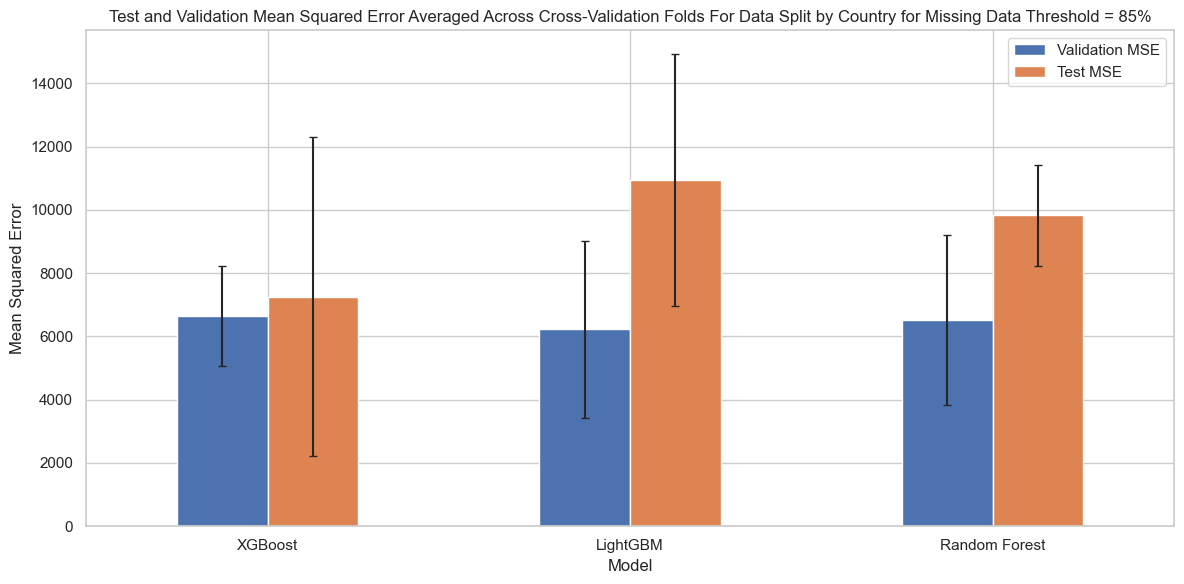

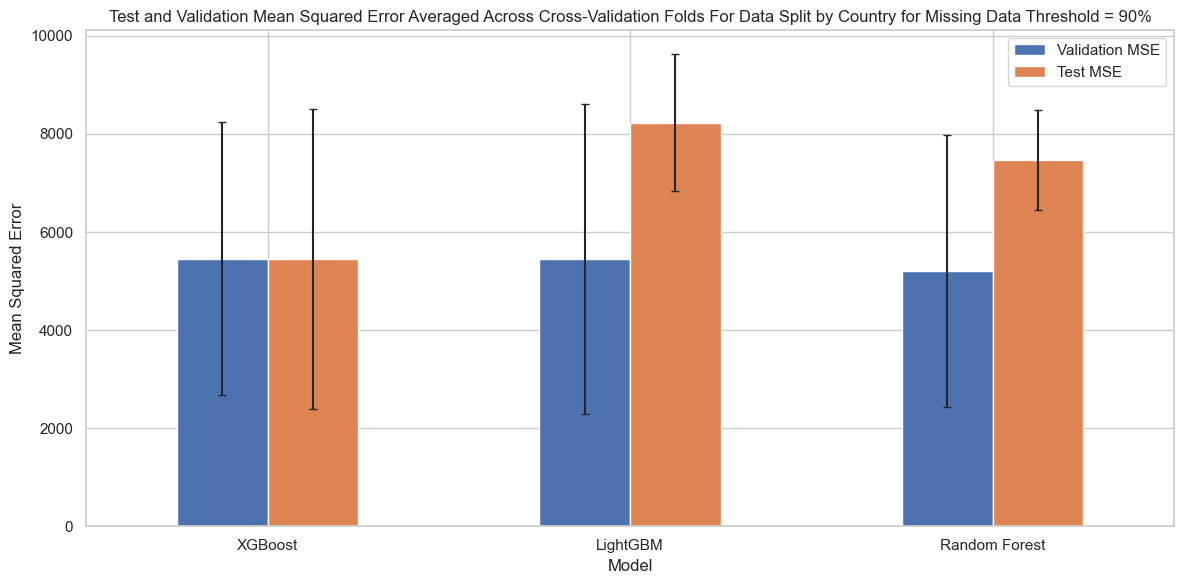

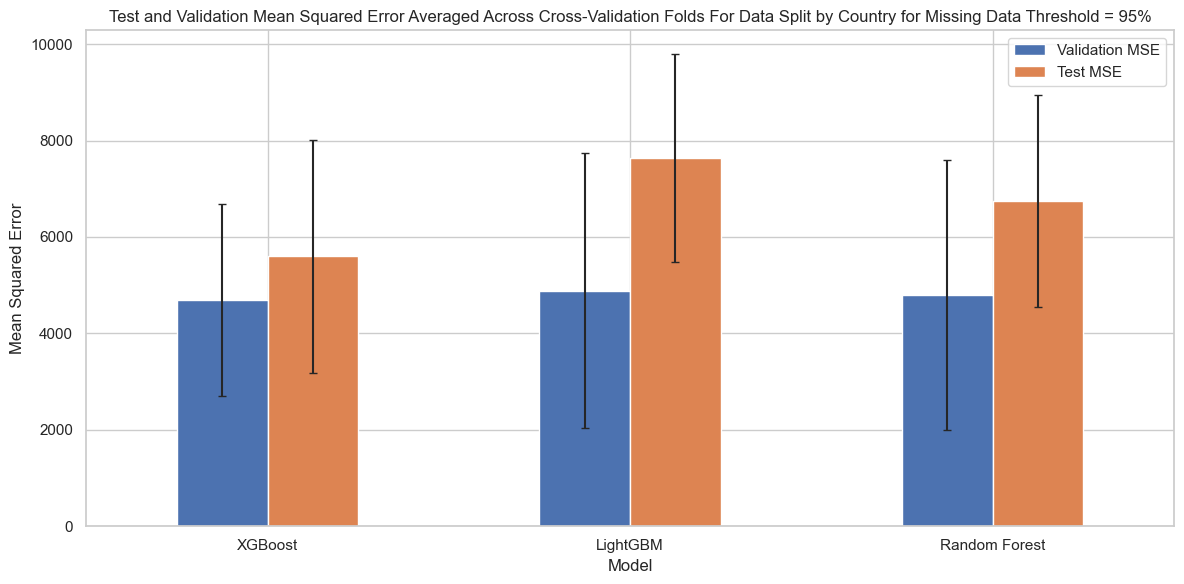

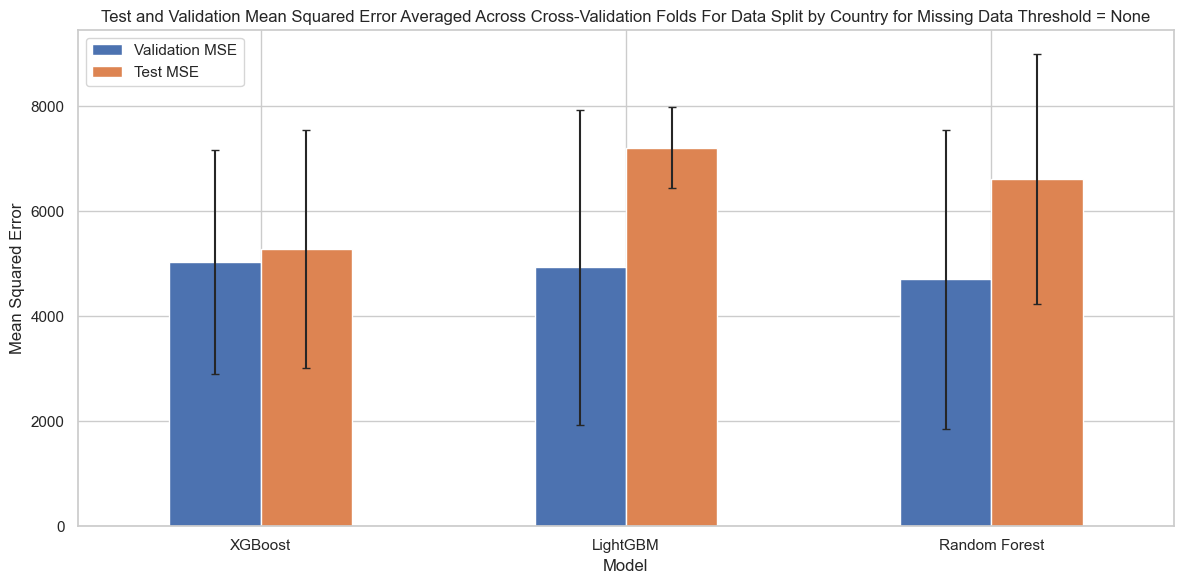

In [147]:
bar_index = ['XGBoost', 'LightGBM', 'Random Forest']

for i in range(4):
    if i == 0:
        threshold = '85%'
    elif i == 1:
        threshold = '90%'
    elif i == 2:
        threshold = '95%'
    else: threshold = 'None'

    ax = mean_validation_scores[i].plot.bar(rot=0, yerr=std_validation_scores[i], figsize=(12, 6), capsize=3)     
    plt.title("Test and Validation Mean Squared Error Averaged Across Cross-Validation Folds For Data Split by Country for Missing Data Threshold = " + threshold)
    plt.xlabel("Model")
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()